In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import pathlib

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

1.15.0


In [3]:
raw_dataset = pd.read_csv('bugs.csv', sep=';', index_col=None,
                      na_values = "?", comment='\t', skipinitialspace=True)

dataset = raw_dataset.copy()
dataset.head()

,CBO,DIT,FanIn,FanOut,LCOM,NOC,RFC,WMC,LOC,Attributes,AttributesInherited,Methods,MethodsInherited,Bugs
0,9,2,1,9,15,0,34,20,122,1,8,6,19,0
1,1,1,1,0,0,0,1,1,4,2,0,1,8,0
2,114,1,102,18,190,6,156,176,484,131,249,20,8,1
3,5,6,1,4,10,0,18,12,33,0,61,5,207,0
4,23,2,1,22,820,0,174,115,673,7,416,41,8,0


In [4]:
train_dataset = dataset.sample(frac=0.8,random_state=0)
test_dataset = dataset.drop(train_dataset.index)

In [5]:
train_stats = train_dataset.astype(float).describe()
train_stats.pop("Bugs ")
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
CBO,798.0,12.013784,17.309379,0.0,3.00,6.0,14.00,156.0
DIT,798.0,2.714286,1.722556,1.0,1.00,2.0,4.00,8.0
FanIn,798.0,4.988722,12.648262,0.0,1.00,2.0,4.00,135.0
FanOut,798.0,7.546366,10.055666,0.0,2.00,4.0,10.00,93.0
LCOM,798.0,349.922306,3199.946664,0.0,6.00,28.0,91.00,81003.0
NOC,798.0,0.713033,2.223769,0.0,0.00,0.0,0.00,26.0
RFC,798.0,77.944862,187.589990,0.0,11.25,30.0,70.00,2603.0
WMC,798.0,58.284461,135.920499,0.0,8.00,21.0,50.00,1680.0
LOC,798.0,226.413534,563.461556,0.0,28.00,75.5,194.50,7341.0
Attributes,798.0,7.027569,18.518579,0.0,1.00,3.0,7.00,276.0


In [6]:
train_labels = train_dataset.pop('Bugs ')
test_labels = test_dataset.pop('Bugs ')

In [7]:
def norm(x):
  return (x - train_stats['mean']) / train_stats['std']
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

In [14]:
def build_model():
  model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=[len(train_dataset.keys())]),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
  ])

  optimizer = tf.keras.optimizers.RMSprop(0.001)

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model



In [15]:
model = build_model()
model.summary()


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 64)                896       
_________________________________________________________________
dense_7 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 65        
Total params: 5,121
Trainable params: 5,121
Non-trainable params: 0
_________________________________________________________________


In [16]:
example_batch = normed_train_data[:10]
example_result = model.predict(example_batch)
example_result

array([[-0.09314729],
       [ 0.0066262 ],
       [-0.10506579],
       [-0.23155439],
       [ 0.26530218],
       [ 0.07912818],
       [-0.14181653],
       [-0.08837407],
       [ 0.16024764],
       [ 0.08296567]], dtype=float32)

In [18]:
EPOCHS = 1000
# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

early_history = model.fit(normed_train_data, train_labels, 
                    epochs=EPOCHS, validation_split = 0.2, verbose=0, 
                    callbacks=[early_stop])

In [19]:
loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=2)

print("Testing set Mean Abs Error: {:5.2f} Bugs".format(mae))

199/199 - 0s - loss: 1.0275 - mean_absolute_error: 0.4302 - mean_squared_error: 1.0275
Testing set Mean Abs Error:  0.43 Bugs


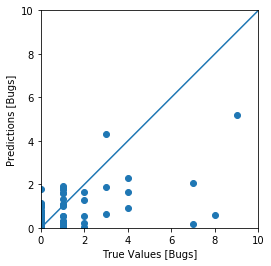

In [20]:
test_predictions = model.predict(normed_test_data).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [Bugs]')
plt.ylabel('Predictions [Bugs]')
lims = [0, 10]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

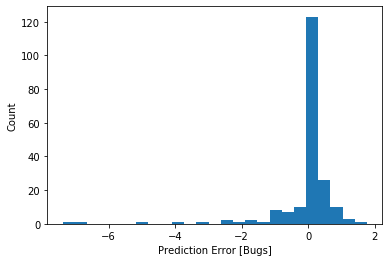

In [21]:
error = test_predictions - test_labels
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [Bugs]")
_ = plt.ylabel("Count")